# Advanced Econometrics (JEM217)– Home Assignment 1 (WS 2025)



**AI Usage**

ChatGPT-5 was used during the preparation of this assignment **solely for grammatical editing and minor code optimization**.  
Any sections where AI-assisted code optimization was applied are explicitly indicated within the notebook.

## Initial Preparation

In this section, we install and load all required R packages necessary for data simulation, estimation, and visualization.  
We also set a fixed random seed (`set.seed(123)`) to ensure that all simulated results are fully reproducible.


In [8]:

req_pkgs <- c("ggplot2","dplyr","quantreg","lmtest","sandwich","car","stargazer","knitr")
for (p in req_pkgs) {
  if (!requireNamespace(p, quietly = TRUE)) {
    install.packages(p, repos = "https://cloud.r-project.org")
  }
}
library(ggplot2)
library(dplyr)
library(quantreg)
library(lmtest)
library(sandwich)
library(car)
library(stargazer)
library(knitr)

set.seed(123) 


## Problem 1: Simulating Used Car Prices 
### 1) Data Simulation

We simulated according to the data‑generating process described in the assignment:
$
\text{price}_i = 1000 - 0.0005\,\text{milage}_i^2 - 5\,\text{years\_old}_i + 50\,\text{convertible}_i + 100\,\text{luxury}_i + \varepsilon_i,\quad \varepsilon_i\sim\mathcal{N}(0,15).
$

We also build a `data.frame` called `cars`.

We chose relatively small sample size 200 to obtain "interesting results" as was mentioned in the assignment.

In [ ]:

N <- 200

# Explanatory variables (X)
milage      <- rnorm(N, mean = 1000, sd = 300)
years_old   <- sample(2:15, N, replace = TRUE)
convertible <- rbinom(N, 1, 0.3)
luxury      <- rbinom(N, 1, 0.2)

# Error term
epsilon <- rnorm(N, mean = 0, sd = 15)

# Outcome
price <- 1000 - 0.0005 * milage^2 - 5 * years_old + 50 * convertible + 100 * luxury + epsilon

cars <- data.frame(price, milage, years_old, convertible, luxury)

# Peek
head(cars)


,price,milage,years_old,convertible,luxury
,<dbl>,<dbl>,<int>,<int>,<int>
1,652.9847,831.8573,8,1,0
2,594.6920,930.9468,4,1,0
3,-122.2930,1467.6125,10,0,0
4,443.0286,1021.1525,14,1,0
5,417.6969,1038.7863,8,0,0
6,-207.3756,1514.5195,15,0,0


### 1a) Descriptive Statistics & Figures

We report summary statistics, a scatterplot matrix, and selected plots. The values are expected.


     price            milage         years_old      convertible  
 Min.   :-987.8   Min.   : 307.2   Min.   : 2.00   Min.   :0.00  
 1st Qu.: 295.6   1st Qu.: 812.3   1st Qu.: 5.00   1st Qu.:0.00  
 Median : 476.1   Median : 982.4   Median : 9.00   Median :0.00  
 Mean   : 449.8   Mean   : 997.4   Mean   : 8.64   Mean   :0.29  
 3rd Qu.: 663.6   3rd Qu.:1170.5   3rd Qu.:12.00   3rd Qu.:1.00  
 Max.   :1022.9   Max.   :1972.3   Max.   :15.00   Max.   :1.00  
     luxury    
 Min.   :0.00  
 1st Qu.:0.00  
 Median :0.00  
 Mean   :0.17  
 3rd Qu.:0.00  
 Max.   :1.00  

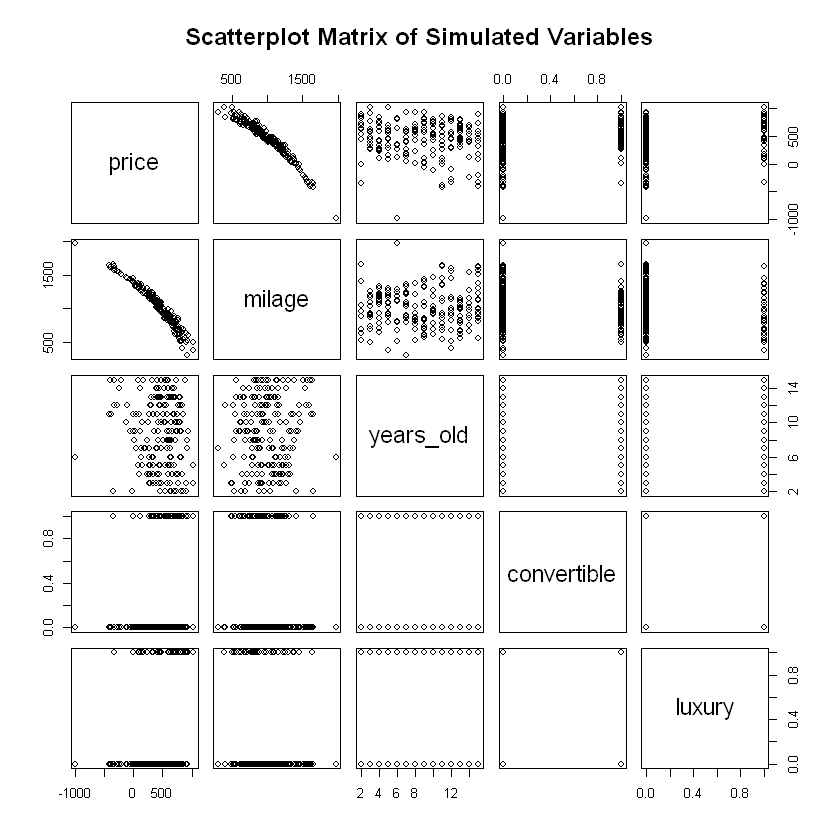

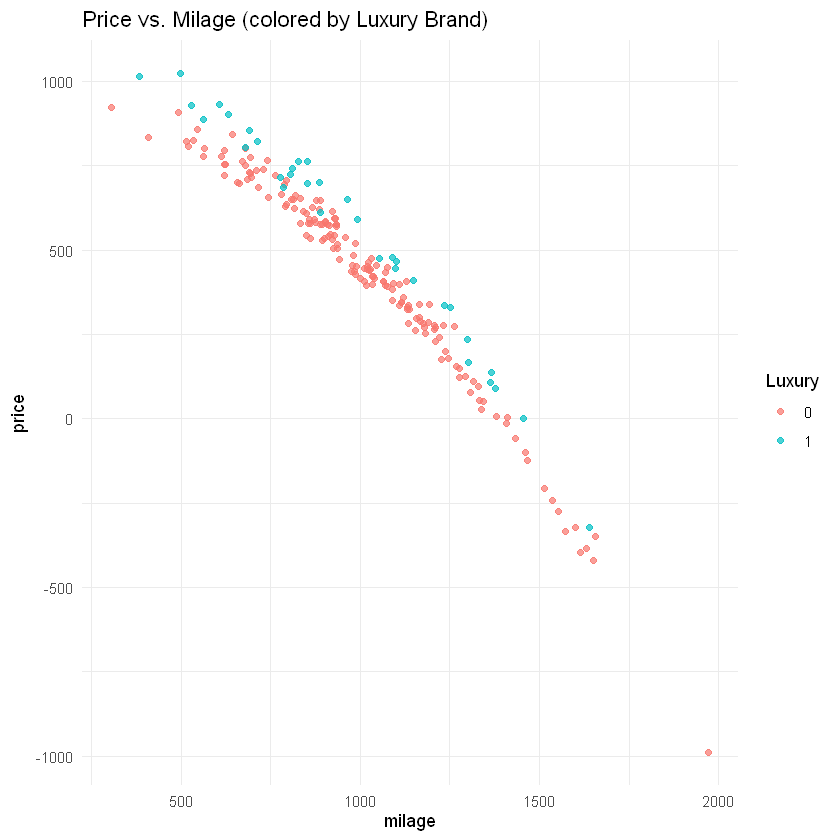

In [ ]:
# Summary statistics
summary(cars)

# A scatterplot matrix of all variables
pairs(cars, main = "Scatterplot Matrix of Simulated Variables")

# Price vs Milage colored by luxury brand
ggplot(cars, aes(x = milage, y = price, color = factor(luxury))) +
  geom_point(alpha = 0.7) +
  labs(title = "Price vs. Milage (colored by Luxury Brand)",
       color = "Luxury") +
  theme_minimal()





### 2) Misspecified Linear Model

We (incorrectly) omit the $\text{milage}^2$ term and include only a linear effect of milage:
$
\text{price}_i = \alpha_0 + \alpha_1\,\text{milage}_i + \alpha_2\,\text{years\_old}_i + \alpha_3\,\text{convertible}_i + \alpha_4\,\text{luxury}_i + u_i.
$

This induces functional form misspecification $\Rightarrow$ biased estimates. Specifically estimates of milage (-1.05) appear very different compared to the true parameter (-0.0005). This is caused by the efect of the linear parameter which is trying to "soak up" the true effect that is non-linear. Intercept is also biased (roughly 500 higher), it is also caused by the functional form misspecification. 

Since the other variables are generater without correlation to milage they are exogenous. This can be proven mathematically, since $\text{Bias}(\beta_j) = \gamma \cdot \pi_j$, where $\gamma$ is the effect of ommited variable (in this case $\text{milage}^2$), $j$ is the index of the other variables and $\pi_j$ is the slope from regressing the omitted variable on regressor $j$. We know that $\pi_j = 0$ and thus bias is zero $\Rightarrow$ those estimates are unbiased and consistent. We can see this visually since those estimates are very close to true value. The difference is caused by small sample size. 

To test this we can first check correlation between regressors and the omited variable. If the correlation is zero as sample size grows this indicates unbiased results. Moreover we did Ramsey Reset test to check functional form misspecification and the small p-value below indicates we can reject $H_0$: Correctly Specified with high confidence (more than 99\%)

In [17]:
model_wrong <- lm(price ~ milage + years_old + convertible + luxury, data = cars)
summary(model_wrong)

cor(cars$milage, cars$milage^2)      
cor(cars$years_old, cars$milage^2)   
cor(cars$convertible, cars$milage^2) 
cor(cars$luxury, cars$milage^2)
resettest(model_wrong, power = 2:3)


Call:
lm(formula = price ~ milage + years_old + convertible + luxury, 
    data = cars)

Residuals:
    Min      1Q  Median      3Q     Max 
-400.48  -14.46   15.99   35.48   73.31 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept) 1509.35641   18.22953  82.797  < 2e-16 ***
milage        -1.04522    0.01507 -69.342  < 2e-16 ***
years_old     -5.86401    1.04802  -5.595 7.38e-08 ***
convertible   61.21950    9.34337   6.552 4.93e-10 ***
luxury        93.42512   11.26295   8.295 1.76e-14 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 59.43 on 195 degrees of freedom
Multiple R-squared:  0.9646,	Adjusted R-squared:  0.9638 
F-statistic:  1327 on 4 and 195 DF,  p-value: < 2.2e-16


[1] 0.9819379

[1] 0.07004344

[1] -0.1413081

[1] -0.04953402


	RESET test

data:  model_wrong
RESET = 716.76, df1 = 2, df2 = 193, p-value < 2.2e-16


### 3) Correct Functional Specification

Now we estimated the true functional form with $\text{milage}^2$:
$
\text{price}_i = \alpha_0 + \beta_1\,\text{milage}_i^2 + \beta_2\,\text{years\_old}_i + \beta_3\,\text{convertible}_i + \beta_4\,\text{luxury}_i + \varepsilon_i.
$

We also test whether the estimated coefficients equal the true values via Wald tests: $1000, -0.0005, -5, 50, 100$. The Wald test has p-value of 31.5\%. This implies that we cannot reject null hypothesis with any meaningful confidence (for example $> 90\%$), and thus we cannot say that those estimates **are not** equal to the true values.

**We did use AI** when conducting the wald test in order to obtain optimal code

In [16]:
model_true <- lm(price ~ I(milage^2) + years_old + convertible + luxury, data = cars)
summary(model_true)

# Wald tests for equality to true parameters
lh_res <- car::linearHypothesis(
  model_true,
  c("(Intercept) = 1000",
    "I(milage^2) = -0.0005",
    "years_old = -5",
    "convertible = 50",
    "luxury = 100")
)
lh_res




Call:
lm(formula = price ~ I(milage^2) + years_old + convertible + 
    luxury, data = cars)

Residuals:
    Min      1Q  Median      3Q     Max 
-41.625  -9.810   0.211   9.937  39.366 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)  1.002e+03  3.180e+00  315.03   <2e-16 ***
I(milage^2) -5.002e-04  1.752e-06 -285.54   <2e-16 ***
years_old   -5.373e+00  2.594e-01  -20.71   <2e-16 ***
convertible  4.909e+01  2.317e+00   21.19   <2e-16 ***
luxury       1.045e+02  2.784e+00   37.53   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 14.7 on 195 degrees of freedom
Multiple R-squared:  0.9978,	Adjusted R-squared:  0.9978 
F-statistic: 2.243e+04 on 4 and 195 DF,  p-value: < 2.2e-16


,Res.Df,RSS,Df,Sum of Sq,F,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,200,43443.49,NA,NA,NA,NA
2,195,42157.81,5,1285.688,1.189384,0.3157863


### 4) Heteroskedasticity Scenario and Corrections

We now simulated a new outcome where the error term is proportional to milage:
$
\text{price}_i = 1000 - 0.0005\,\text{milage}_i^2 - 5\,\text{years\_old}_i + 50\,\text{convertible}_i + 100\,\text{luxury}_i + \text{milage}_i\ \cdot \varepsilon_i.
$



Since the multiplicative heteroskedasticity is proportional to mileage. OLS coefficients remain unbiased and consistent (exogeneity holds), but usual OLS standard errors are invalid and efficiency is lost. The B-P test has very low p-value thus we reject null hypothesis of homoskedasticity. With use of robust (HC1) SEs we fixed the inference with misspecified variance. Next we divided the whole model with $\frac{1}{\text{milage}}$, which is the true form of heteroskedasticity further improving SEs, but in proces we changed the interpetation of the intercept which is now $\frac{\text{intercept}}{\text{milage}}$, similarly ve divided all other variables including $y$ and we now only have linear effect of milage, thus our interpretation changes.

In [ ]:
# Multiplicative heteroskedasticity
epsilon2 <- rnorm(N, 0, 15)
price2 <- 1000 - 0.0005 * milage^2 - 5 * years_old + 50 * convertible + 100 * luxury + milage * epsilon2

cars2 <- data.frame(price2, milage, years_old, convertible, luxury)

# "True" structural regressors 
model_het <- lm(price2 ~ I(milage^2) + years_old + convertible + luxury, data = cars2)
summary(model_het)

# Breusch-Pagan test for heteroskedasticity
bp <- bptest(model_het)
bp

# Robust standard errors
robust_vcov <- vcovHC(model_het, type = "HC1")
robust_se <- sqrt(diag(robust_vcov))

# Coefficients with robust SEs
lmtest::coeftest(model_het, vcov = robust_vcov)

# Known-form correction: dividing both sides by milage
cars2 <- cars2 %>% mutate(
  price2_adj   = price2 / milage,
  milage2_adj  = (milage^2) / milage,   
  years_adj    = years_old / milage
)

model_corrected <- lm(price2_adj ~ milage2_adj + years_adj + convertible + luxury, data = cars2)
summary(model_corrected)




Call:
lm(formula = price2 ~ I(milage^2) + years_old + convertible + 
    luxury, data = cars2)

Residuals:
   Min     1Q Median     3Q    Max 
-58767  -7744    623   9595  59555 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)  
(Intercept)  5.359e+03  3.348e+03   1.601   0.1110  
I(milage^2)  2.569e-04  1.844e-03   0.139   0.8893  
years_old   -5.964e+02  2.731e+02  -2.184   0.0302 *
convertible  1.836e+03  2.439e+03   0.753   0.4525  
luxury      -1.244e+03  2.931e+03  -0.425   0.6716  
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 15480 on 195 degrees of freedom
Multiple R-squared:  0.02921,	Adjusted R-squared:  0.009297 
F-statistic: 1.467 on 4 and 195 DF,  p-value: 0.2138



	studentized Breusch-Pagan test

data:  model_het
BP = 37.088, df = 4, p-value = 1.728e-07



t test of coefficients:

               Estimate  Std. Error t value Pr(>|t|)  
(Intercept)  5.3593e+03  3.8160e+03  1.4044  0.16178  
I(milage^2)  2.5692e-04  2.9130e-03  0.0882  0.92981  
years_old   -5.9641e+02  2.7156e+02 -2.1963  0.02925 *
convertible  1.8359e+03  2.1942e+03  0.8367  0.40376  
luxury      -1.2442e+03  3.4768e+03 -0.3579  0.72083  
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1



Call:
lm(formula = price2_adj ~ milage2_adj + years_adj + convertible + 
    luxury, data = cars2)

Residuals:
    Min      1Q  Median      3Q     Max 
-43.457  -8.863  -0.087   9.836  38.537 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)  
(Intercept)  1.178e+01  5.745e+00   2.051   0.0416 *
milage2_adj -6.954e-03  4.199e-03  -1.656   0.0993 .
years_adj   -4.099e+02  2.202e+02  -1.861   0.0642 .
convertible  9.042e-01  2.280e+00   0.397   0.6921  
luxury      -1.120e+00  2.738e+00  -0.409   0.6828  
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 14.47 on 195 degrees of freedom
Multiple R-squared:  0.02431,	Adjusted R-squared:  0.004293 
F-statistic: 1.215 on 4 and 195 DF,  p-value: 0.3059


### 5) Quantile Regression (τ = 0.05 to 0.95 by 0.05)

We estimated quantile regressions for the correctly specified model and plot how key coefficients vary across quantiles. This reveals distributional heterogeneity beyond the conditional mean. We can see that the estimates of different quantiles vary singificantly, for example for $\text{milage}^2$ variable. This implies that quantile regression can uncover deeper relationships of this dataset.

,(Intercept),I(milage^2),years_old,convertible,luxury,tau
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,977.5517,-0.0005007882,-4.893971,45.13564,90.68729,0.05
2,979.2472,-0.0004983454,-5.138985,48.22828,108.28120,0.10
3,985.9332,-0.0004989380,-5.478099,50.12994,107.91111,0.15
4,986.8641,-0.0004993317,-5.378036,52.00613,106.61015,0.20
5,992.3923,-0.0005007132,-5.407758,49.08453,107.27943,0.25
6,995.8403,-0.0005014957,-5.471076,49.14202,105.99357,0.30


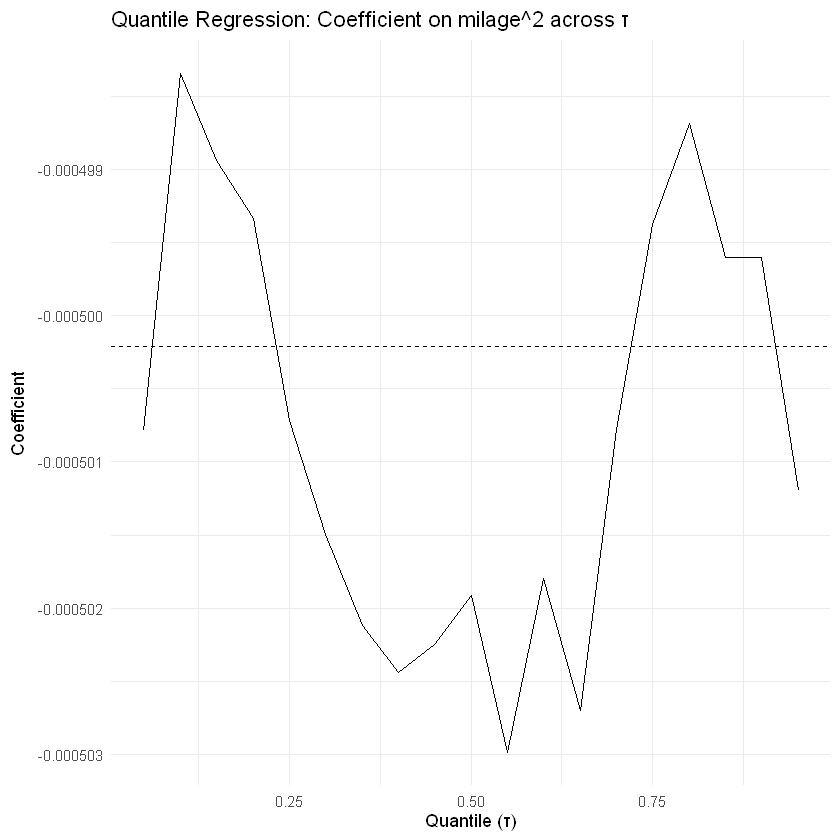

In [ ]:
taus <- seq(0.05, 0.95, by = 0.05)
qr_models <- lapply(taus, function(tau) {
  quantreg::rq(price ~ I(milage^2) + years_old + convertible + luxury, data = cars, tau = tau)
})

# Coefficients
coef_mat <- sapply(qr_models, coef)
coef_df <- as.data.frame(t(coef_mat))
coef_df$tau <- taus

head(coef_df)

# Plots
  ggplot(coef_df, aes(x = tau, y = `I(milage^2)`)) +
    geom_line() +
    geom_hline(yintercept = coef(model_true)["I(milage^2)"], linetype = "dashed") +
    labs(title = "Quantile Regression: Coefficient on milage^2 across τ",
        x = "Quantile (τ)", y = "Coefficient") +
    theme_minimal()


